In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import re

In [2]:
#Loading data
DATA_PATH = Path(r'C:\Users\ftsky\PycharmProjects\COMP5434_project\data_source')
OUTPUT_PATH = Path(r'C:\Users\ftsky\PycharmProjects\COMP5434_project\output')

train = pd.read_csv(DATA_PATH / 'training.csv')
valid = pd.read_csv(DATA_PATH / 'validation.csv')
test = pd.read_csv(DATA_PATH / 'testing.csv')


In [3]:
#Found there are 34 null value in condition column
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999 entries, 0 to 6998
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   recordId       6999 non-null   int64 
 1   drugName       6999 non-null   object
 2   condition      6965 non-null   object
 3   reviewComment  6999 non-null   object
 4   date           6999 non-null   object
 5   usefulCount    6999 non-null   int64 
 6   sideEffects    6999 non-null   object
 7   rating         6999 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 437.6+ KB


In [4]:
#The range of usefulCount is from 0 to 949
train.describe()

,recordId,usefulCount,rating
count,6999.000000,6999.000000,6999.000000
mean,117818.948564,28.189027,3.712102
std,66920.098771,40.007725,1.556816
min,6.000000,0.000000,1.000000
25%,59038.000000,6.000000,2.000000
50%,118973.000000,16.000000,4.000000
75%,175369.000000,35.000000,5.000000
max,232143.000000,949.000000,5.000000


In [5]:
print(f'Is the "recordId" unique? {len(train) == train.recordId.nunique()}')
print(f'Number of labels for rating:{train.rating.nunique()}')

Is the "recordId" unique? True
Number of labels for rating:5


In [6]:
#Class 2 and 3 has lower proportion
train.rating.value_counts(normalize=True)

5    0.489356
1    0.182312
4    0.170882
3    0.084584
2    0.072868
Name: rating, dtype: float64

In [7]:
temp = train.copy()

In [8]:
#Exploring 'drugName'
temp['drugName'] = train['drugName'].apply(lambda x: x.lower().strip())
print(temp.drugName.head(5))
print('-'*50)
print(temp.drugName.value_counts())
print('-'*50)
temp['valid_drugName'] = valid['drugName'].apply(lambda x: x.lower().strip())
print(f"Number of drug unseen in validation set: {len(set(temp['valid_drugName'])-set(temp['drugName']))}")

0        mirtazapine
1         mesalamine
2            bactrim
3           contrave
4    cyclafem 1 / 35
Name: drugName, dtype: object
--------------------------------------------------
levonorgestrel                        174
etonogestrel                          145
ethinyl estradiol / norethindrone     102
ethinyl estradiol / levonorgestrel     86
nexplanon                              82
                                     ... 
patanase                                1
ibrance                                 1
levalbuterol                            1
eptifibatide                            1
telaprevir                              1
Name: drugName, Length: 1300, dtype: int64
--------------------------------------------------
Number of drug unseen in validation set: 105


In [9]:
#Exploring 'condition'
print(temp.condition.head(5))
print('-'*50)

#As the following code cannot not be execute, and the error shows there are floating point number inside
#temp.condition = train.condition.apply(lambda x: x.lower().strip())

temp['check_cond'] = temp.condition.apply(lambda x: bool(re.findall(r'\d',str(x))))
print(f'Number of rows that condition value are number: {temp.check_cond.sum()}')
print(temp[temp['check_cond']==True]['condition'].head(5))
print('-'*50)

#Here shows some wrong information, clearly not a condition value
#This needed to be further remove

0                      Depression
1    Crohn's Disease, Maintenance
2         Urinary Tract Infection
3                     Weight Loss
4                   Birth Control
Name: condition, dtype: object
--------------------------------------------------
Number of rows that condition value are number: 144
35                                Diabetes, Type 2
66                                Diabetes, Type 1
96                                Diabetes, Type 1
136    12</span> users found this comment helpful.
137                               Diabetes, Type 2
Name: condition, dtype: object
--------------------------------------------------


In [10]:
#Exploring 'condition' cont.

#Let's impute all the wrong information and null values to unknown first and continue the exploration
temp['condition'] = temp['condition'].apply(
    lambda x: re.sub(r'(\d*<\/span>\s*users\s*found\s*this\s*comment\s*helpful.)', 'unknown', str(x)))
temp['condition'] = temp['condition'].fillna('unknown')
#check if they are imputed
print(temp[temp['check_cond']==True]['condition'].head(5))
print(f'Number of null value in condition: {temp.condition.isnull().sum()}')
print('-'*50)
temp['valid_cond'] = valid['condition'].apply(lambda x: str(x).lower().strip())
print(f"Number of condition unseen in validation set: {len(set(temp['valid_cond'])-set(temp['condition']))}")
print('-'*50)
print(temp.condition.value_counts(normalize=True))
print('-'*50)
# About 18% of the conditon is Birth Control

35     Diabetes, Type 2
66     Diabetes, Type 1
96     Diabetes, Type 1
136             unknown
137    Diabetes, Type 2
Name: condition, dtype: object
Number of null value in condition: 0
--------------------------------------------------
Number of condition unseen in validation set: 204
--------------------------------------------------
Birth Control                       0.180740
Depression                          0.061009
Pain                                0.038577
Anxiety                             0.035434
Acne                                0.033433
                                      ...   
Precocious Puberty                  0.000143
Diaper Rash                         0.000143
Juvenile Rheumatoid Arthritis       0.000143
cal Segmental Glomerulosclerosis    0.000143
Diagnosis and Investigation         0.000143
Name: condition, Length: 393, dtype: float64
--------------------------------------------------


In [11]:
#Exploring 'reviewComment'
print(temp.reviewComment.head(20))
#There are many non word characters can be seen

0     "I&#039;ve tried a few antidepressants over th...
1     "My son has Crohn&#039;s disease and has done ...
2                         "Quick reduction of symptoms"
3     "Contrave combines drugs that were used for al...
4     "I have been on this birth control for one cyc...
5     "4 days in on first 2 weeks.  Using on arms an...
6     "I&#039;ve had the copper coil for about 3 mon...
7     "This has been great for me. I&#039;ve been on...
8     "Ive been on Methadone for over ten years and ...
9     "I was on this pill for almost two years. It d...
10    "Holy Hell is exactly how I feel. I had been t...
11    "Honestly its day one on the 3 day treatment. ...
12    "This is a waste of money.  Did not curb my ap...
13                   "No problems, watch what you eat."
14    "Ditto on rebound sleepless when discontinued....
15    "A doctor in the ER prescribed me 200 mg of Pr...
16    "I smoked for 50+ years.  Took it for one week...
17    "So I was on Ginanvi for about 3 months be

In [12]:
#Exploring 'reviewComment' cont.
print(f'Is there any duplicated review comment? {bool(len(temp[temp.duplicated(["reviewComment"],keep=False)]))}')
if bool(len(temp[temp.duplicated(["reviewComment"],keep=False)])):
    checking_review = temp[temp.duplicated(["reviewComment"],keep=False)].sort_values('reviewComment')
    print(checking_review.head(5))
#The duplicated comment seems to have the same date and the same condition but different drugs
#May assume that they are one treatment with multiple drugs consuming.

Is there any duplicated review comment? True
      recordId           drugName            condition  \
4774    209876           vesicare    Overactive Bladde   
4067     18823        solifenacin    Overactive Bladde   
5356    148416             mirena        Birth Control   
756     142562     levonorgestrel        Birth Control   
6004     59012  divalproex sodium  Migraine Prevention   

                                          reviewComment              date  \
4774  "After 5 days taking vesicare I feel like I ha...  November 6, 2016   
4067  "After 5 days taking vesicare I feel like I ha...  November 6, 2016   
5356  "After having my first child, I decided to try...   August 27, 2017   
756   "After having my first child, I decided to try...   August 27, 2017   
6004  "After trying Topamax for months with no relie...     March 7, 2008   

      usefulCount                    sideEffects  rating valid_drugName  \
4774           22          Moderate Side Effects       1            

In [13]:
#Exploring 'reviewComment' cont.

#To check if the assumption is correct
print(len(temp[temp.duplicated(["reviewComment"],keep=False)]))
print(len(temp[temp.duplicated(['reviewComment','condition','date'],keep=False)]))
print(len(temp[temp.duplicated(['reviewComment','date'],keep=False)]))
print('-'*100)

#There 6 of them has the same reviewComment and different date
#The reviewComment is very common, the assumption can still be correct
checking_id = set(temp[temp.duplicated(["reviewComment"],keep=False)]['recordId']) - set(temp[temp.duplicated(['reviewComment','date'],keep=False)]['recordId'])
print(temp[temp['recordId'].isin(checking_id)].sort_values('reviewComment'))
print('-'*100)

#Except the 6 records above, there are 4 more records have different condition and different date
checking_id = set(temp[temp.duplicated(['reviewComment','date'],keep=False)]['recordId']) - set(temp[temp.duplicated(['reviewComment','condition','date'],keep=False)]['recordId']) 
print(temp[temp['recordId'].isin(checking_id)].sort_values('reviewComment'))
print('-'*100)
#Except for the null values, there are two records has the same date, reviewComment and with a pair of very close condition value
#If the assumption is correct, the 'Glioblastoma Multi' can be replaced by 'Glioblastoma Multiforme'

204
194
198
----------------------------------------------------------------------------------------------------
      recordId    drugName                 condition reviewComment  \
509     229124   tadalafil         Not Listed / Othe       "Good."   
3107    184674  aclidinium                      COPD       "Good."   
498      30138    klonopin           Bipolar Disorde      "Great."   
4833     77276  lorcaserin               Weight Loss      "Great."   
1215    140390   sterapred  Conjunctivitis, Allergic   "Very good"   
2395    176650   lorazepam                   Anxiety   "Very good"   

                    date  usefulCount            sideEffects  rating  \
509    November 23, 2011            0  Moderate Side Effects       5   
3107       June 11, 2013           27      Mild Side Effects       4   
498   September 27, 2013           23        No Side Effects       5   
4833     August 22, 2013           52    Severe Side Effects       5   
1215      August 1, 2012            

In [14]:
#Exploring 'sideEffects'
print('The unique value of sideEffects:')
print(temp.sideEffects.unique())
print(f'\nIs there more than 5 categories? {valid.sideEffects.unique() not in temp.sideEffects.unique()}')
# This shows they are ordinal categoical variables

The unique value of sideEffects:
['Mild Side Effects' 'Severe Side Effects' 'No Side Effects'
 'Extremely Severe Side Effects' 'Moderate Side Effects']

Is there more than 5 categories? False


In [15]:
#Exploring 'sideEffects' cont.

#As the sideEffects is ordinal, it can be replaced by numbers and check it correlation between the rating
side_Effect_dict = {'No Side Effects':1,'Mild Side Effects':2,'Moderate Side Effects':3,'Severe Side Effects':4,'Extremely Severe Side Effects':5}
temp['side_Effect'] = temp['sideEffects'].apply(lambda x: side_Effect_dict[x])

#Compute correlation matrix for all the numeric features
temp[['usefulCount','rating','side_Effect']].corr()
#As shown, the sideEffect has very weak negative correlation with rating, nearly zero.
#Meaning the more severe the side effect, the lower rating is not True, vice versa
#The matrix also shows some correlation between usefulCount and rating, which is 0.2


,usefulCount,rating,side_Effect
usefulCount,1.000000,0.217279,-0.015661
rating,0.217279,1.000000,-0.004918
side_Effect,-0.015661,-0.004918,1.000000


In [16]:
import matplotlib.pyplot as plt

<AxesSubplot:title={'center':'side_Effect vs Date'}, xlabel='Date', ylabel='side_Effects'>

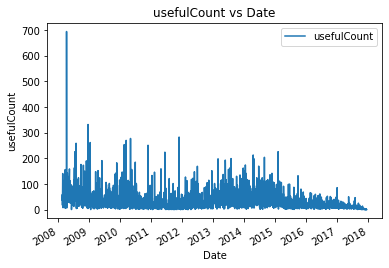

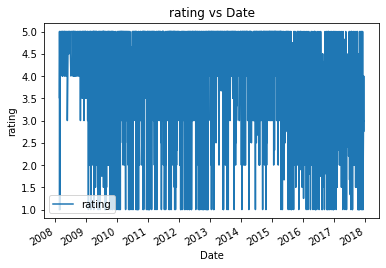

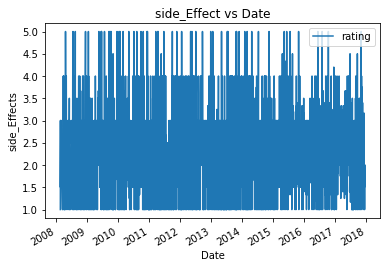

In [17]:
#Exploring the 'date'
#Exploring if the features related to time domain.

temp['date'] = temp['date'].apply(pd.to_datetime)

#The graph show there are outlier in usefulCount
temp[['date','usefulCount']].groupby('date').agg(usefulCount=('usefulCount','mean')).plot(title='usefulCount vs Date',xlabel='Date',ylabel='usefulCount')
#The rating between 2008 and 2009 are nearly all high rating
temp[['date','rating']].groupby('date').agg(rating=('rating','mean')).plot(title='rating vs Date',xlabel='Date',ylabel='rating')
#Very seldom has severe side effects
temp[['date','side_Effect']].groupby('date').agg(rating=('side_Effect','mean')).plot(title='side_Effect vs Date',xlabel='Date',ylabel='side_Effects')
